In [4]:
import helper
import pandas as pd
from utils import *

import time
import numpy as np
import math
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader
from torch import nn

from IPython.display import Image


First, we read in the data, dropping the index and the date.

In [5]:
df = pd.read_csv('atlantic (2).csv')

df.drop(['status_of_system', 'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8','Unnamed: 9', 
        'Unnamed: 10', 'Unnamed: 11','Unnamed: 12', 'Unnamed: 13', 'Unnamed: 14', 
        'Unnamed: 15', 'Unnamed: 16', 'Unnamed: 17', 'Unnamed: 18'], inplace=True, axis=1)
df['date'] = pd.to_datetime(df['date'], format = "%Y%m%d").dt.strftime('%Y-%m-%d')


df['tmrw windspeed'] =  df['max_sustained_wind'].shift(-1)

df.to_csv('cleanedHurricaneData.csv', index=False)

df['date'] = df['date'].apply(lambda x: float(x.split()[0].replace('-', '')))
df['latitude'] = df['latitude'].map(lambda x: float(x.rstrip('NEWS')))
df['longitude'] = df['longitude'].map(lambda x: float(x.rstrip('NEWS')))

df['max_sustained_wind'] =  df['max_sustained_wind'].fillna(method='ffill', limit=1000)
df['max_sustained_wind'] =  df['max_sustained_wind'].fillna(method='bfill', limit=1000)
df['central_pressure'] = df['central_pressure'].fillna(method='ffill', limit=1000)
df['central_pressure'] = df['central_pressure'].fillna(method='bfill', limit=1000)
df['tmrw windspeed'] = df['tmrw windspeed'].fillna(method='ffill', limit=1000)
df['tmrw windspeed'] = df['tmrw windspeed'].fillna(method='bfill', limit=1000)

df

,date,latitude,longitude,max_sustained_wind,central_pressure,tmrw windspeed
0,18510625.0,28.0,94.8,80,961.0,80.0
1,18510625.0,28.0,95.4,80,961.0,80.0
2,18510625.0,28.0,96.0,80,961.0,80.0
3,18510625.0,28.1,96.5,80,961.0,80.0
4,18510625.0,28.2,96.8,80,961.0,70.0
...,...,...,...,...,...,...
49100,20151112.0,41.3,50.4,55,981.0,55.0
49101,20151112.0,41.9,49.9,55,983.0,50.0
49102,20151113.0,41.5,49.2,50,985.0,45.0
49103,20151113.0,40.8,47.5,45,985.0,45.0


We identify the dependent and independent variables:

In [6]:
target = "tmrw windspeed"

In [7]:
features = list(df.columns.difference(["date", 'tmrw windspeed']))
features

['central_pressure', 'latitude', 'longitude', 'max_sustained_wind']

## Data Processing

To process the data, we first split it into training and test data, where two-thirds of the data is used for training, and the last third is used for testing.

In [8]:
size = int(len(df) * 0.67)

df_train = df.loc[:size].copy()
df_test = df.loc[size:].copy()

Next, in order to ensure that some values due to their mangnitude do not inherently dominate the features, we standardize their values.

In [9]:
target_mean = df_train[target].mean()
target_stdev = df_train[target].std()

for c in df_train.columns:
    mean = df_train[c].mean()
    stdev = df_train[c].std()

    df_train[c] = (df_train[c] - mean) / stdev
    df_test[c] = (df_test[c] - mean) / stdev

In [10]:
from Factory import SequenceDataset

Finally, the last step in the data processing to prepare for LSTM is to prepare the data in a sequence of past observations. Preparation of the LSTM on time series data means that it uses a certain number of past observations to predict the future. In this case, the sequence length decides how many days the LSTM considers in advance. If the sequence length is $n$, then the LSTM considers the last $n$ observations to predict the $n+1$th day.

We decided the sequence length as 3 for purposes of this notebook.

In [11]:
torch.manual_seed(101)

batch_size = 1
sequence_length = 3

train_dataset = SequenceDataset(
    df_train,
    target=target,
    features=features,
    sequence_length=sequence_length
)
test_dataset = SequenceDataset(
    df_test,
    target=target,
    features=features,
    sequence_length=sequence_length
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

X, y = next(iter(train_loader))

print("Features shape:", X.shape)
print("Target shape:", y.shape)

Features shape: torch.Size([1, 3, 4])
Target shape: torch.Size([1])


# Classical LSTM

We first define two functions:
    
- train_model: function to train the model based on the batches of data
- test_model: function to test the model on the testing data
    
We print the loss at the end to understand how the model is performing with regards to the data.

In [12]:
def train_model(data_loader, model, loss_function, optimizer):
    num_batches = len(data_loader)
    total_loss = 0
    model.train()
    
    for X, y in data_loader:
        output = model(X)
        loss = loss_function(output, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / num_batches
    print(f"Train loss: {avg_loss}")
    return avg_loss

def test_model(data_loader, model, loss_function):
    
    num_batches = len(data_loader)
    total_loss = 0

    model.eval()
    with torch.no_grad():
        for X, y in data_loader:
            output = model(X)
            total_loss += loss_function(output, y).item()

    avg_loss = total_loss / num_batches
    print(f"Test loss: {avg_loss}")
    return avg_loss

## Running the Classical LSTM

To understand our implementation of QLSTM, we first explain our implementation LSTM. LSTM follows the following structure:

<img src="lstm2.jpg" alt="drawing" width="400"/>

Image taken from: Quantum Long Short-Term Memory, https://arxiv.org/pdf/2009.01783.pdf (Samuel Yen-Chi Chen, Shinjae Yoo, and Yao-Lung L. Fang (2020)) 

Simply put, LSTM uses 4 neural network layers in each LSTM cell. They are:

- Forget layer
- Input layer
- Update layer
- Output layer

We can see the corresponding layers in the W cells in the picture above. We will be skipping the technical details, but it is important to note that these 4 layers are the keys to building an LSTM neural network model that we can train and eventually use to predict. They usually take the form of a normal NN layer (like a linear layer with reLU or convolutional layers).

LSTMs are well studied, and there is a native implementation of it in PyTorch to begin with, so we use a slightly modified version of it for the time series LSTM that we perform here. The code for the time series LSTM was reused from:

How to use PyTorch LSTMs for time series regression: https://www.crosstab.io/articles/time-series-pytorch-lstm, Brian Kent.

In the following code, we train LSTM to predict future stock prices, and then test it on the test dataset. The learning rate of 0.0001 was decided after some experimentation, where we chose the learning rate that gave accurate results. The number of epochs we use is 20, by which it would have converged and thus would suffice for the purposes of this notebook. After that, we visualize three different graphs: the comparison between the real stock prices and the ones given by the model; and the evolution of test loss and training loss by epoch.

In [13]:
from Factory import ShallowRegressionLSTM

In [14]:
learning_rate = 0.0001
num_hidden_units = 16

model = ShallowRegressionLSTM(num_sensors=len(features), hidden_units=num_hidden_units)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [15]:
classical_loss_train = []
classical_loss_test = []
print("Untrained test\n--------")
test_loss = test_model(test_loader, model, loss_function)
print()
classical_loss_test.append(test_loss)

for ix_epoch in range(20):
    print(f"Epoch {ix_epoch}\n---------")
    train_loss = train_model(train_loader, model, loss_function, optimizer=optimizer)
    test_loss = test_model(test_loader, model, loss_function)
    print()
    classical_loss_train.append(train_loss)
    classical_loss_test.append(test_loss)

Untrained test
--------
Test loss: 0.8899269153209013

Epoch 0
---------
Train loss: 0.20227312866704775
Test loss: 0.07409255407520715

Epoch 1
---------
Train loss: 0.07467485485068606
Test loss: 0.06580189452744528

Epoch 2
---------
Train loss: 0.07098198762215788
Test loss: 0.06414364845743158

Epoch 3
---------
Train loss: 0.06961981740350873
Test loss: 0.06324062003078468

Epoch 4
---------
Train loss: 0.06855510066114552
Test loss: 0.06238505750275436

Epoch 5
---------
Train loss: 0.06793607295424171
Test loss: 0.06193935154770442

Epoch 6
---------
Train loss: 0.06755401081242589
Test loss: 0.06114914129726301

Epoch 7
---------
Train loss: 0.06723545395655547
Test loss: 0.06101008793627583

Epoch 8
---------
Train loss: 0.06690774040433468
Test loss: 0.061544282792490274

Epoch 9
---------
Train loss: 0.06677328209729545
Test loss: 0.0605619740197684

Epoch 10
---------
Train loss: 0.06644463626066927
Test loss: 0.060627418947026716

Epoch 11
---------
Train loss: 0.06645323

We then use the model to predict the test set, and then compare the results of the prediction to the real values.

In [16]:
def predict(data_loader, model):
    """Just like `test_loop` function but keep track of the outputs instead of the loss
    function.
    """
    output = torch.tensor([])
    model.eval()
    with torch.no_grad():
        for X, _ in data_loader:
            y_star = model(X)
            output = torch.cat((output, y_star), 0)
    
    return output

In [17]:
train_eval_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

ystar_col = "Model forecast"
df_train[ystar_col] = predict(train_eval_loader, model).numpy()
df_test[ystar_col] = predict(test_loader, model).numpy()

df_out = pd.concat((df_train, df_test))[[target, ystar_col]]

for c in df_out.columns:
    df_out[c] = df_out[c] * target_stdev + target_mean

print(df_out)

       tmrw windspeed  Model forecast
0                80.0       75.514397
1                80.0       75.394402
2                80.0       75.197998
3                80.0       74.938644
4                70.0       74.700478
...               ...             ...
49100            55.0       50.698715
49101            50.0       51.920261
49102            45.0       47.955410
49103            45.0       42.684589
49104            45.0       43.663864

[49106 rows x 2 columns]


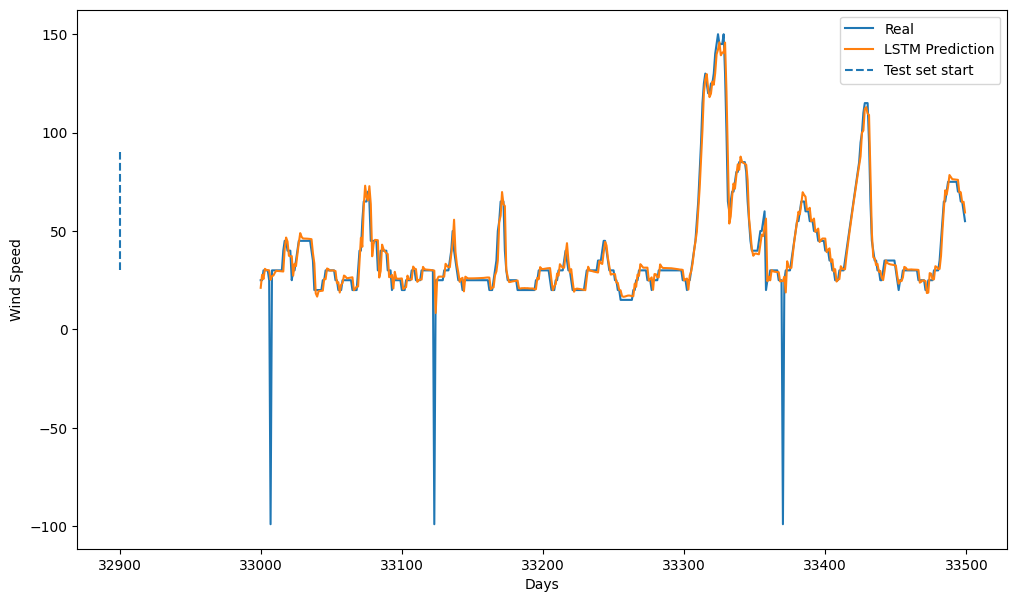

In [34]:
plt.figure(figsize=(12, 7))
plt.plot(range(len(df_out)), df_out["tmrw windspeed"], label = "Real")
plt.plot(range(len(df_out)), df_out["Model forecast"], label = "LSTM Prediction")
plt.ylabel('Wind Speed')
plt.xlabel('Days')
plt.vlines(size, ymin = 30, ymax = 90, label = "Test set start", linestyles = "dashed")
plt.legend()
plt.show()

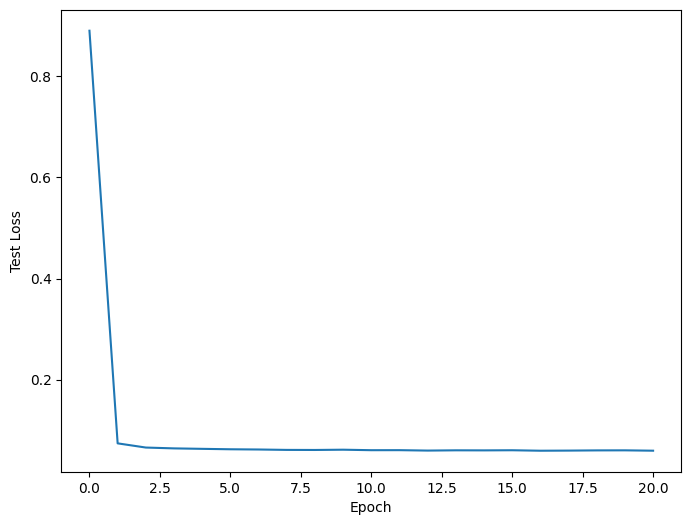

In [20]:
plt.figure(figsize=(8, 6))
plt.plot(range(21), classical_loss_test)
plt.ylabel('Test Loss')
plt.xlabel('Epoch')
plt.show()

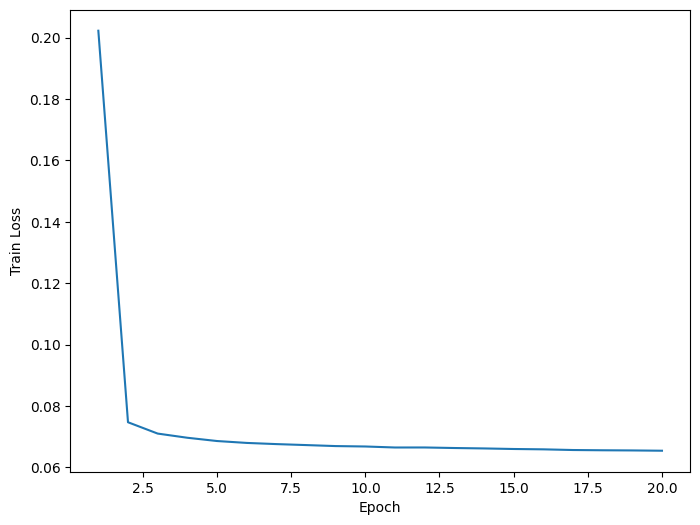

In [21]:
plt.figure(figsize=(8, 6))
plt.plot(range(1, 21), classical_loss_train)
plt.ylabel('Train Loss')
plt.xlabel('Epoch')
plt.show()